In [28]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from pycaret.classification import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
df = pd.read_parquet('dataset_final_sem_reamostragem.parquet')

df = df.drop(columns=['tensao_1', 'corrente_499'])

df.head()

,temp,irrad,label_sujeira,label_sombra,corrente_1,tensao_2,corrente_2,tensao_3,corrente_3,tensao_4,...,corrente_494,tensao_495,corrente_495,tensao_496,corrente_496,tensao_497,corrente_497,tensao_498,corrente_498,tensao_499
0,57.27,1015.756377,Limpo,Ensaio 1,9.633357,14.642546,9.623563,24.771224,9.617146,34.459525,...,0.040642,803.358322,0.040642,803.358322,0.040642,803.358322,0.040642,803.358322,0.040642,804.018888
1,36.37,1040.200000,Limpo,Ensaio 1,9.670000,17.000000,9.660000,25.700000,9.640000,34.800000,...,0.010000,881.500000,0.010000,881.100000,0.010000,881.100000,0.010000,881.100000,0.010000,882.700000
2,47.79,1094.686567,Limpo,Ensaio 1,10.395877,15.523300,10.382924,25.651979,10.374368,35.780657,...,0.029947,825.157000,0.029947,825.157000,0.029947,825.157000,0.029947,824.936811,0.029947,825.817566
3,47.79,1098.200000,Limpo,Ensaio 1,10.400000,15.500000,10.380000,25.700000,10.370000,35.800000,...,0.030000,825.200000,0.030000,825.200000,0.030000,825.200000,0.030000,824.900000,0.030000,825.800000
4,50.79,1183.952853,Limpo,Ensaio 1,10.673835,16.404055,10.673835,27.853865,10.673835,39.083487,...,0.029947,820.753226,0.029947,820.753226,0.029947,820.753226,0.029947,820.753226,0.029947,821.633981


In [ ]:
c_cols = [c for c in df.columns if 'corrente' in c]
v_cols = [c for c in df.columns if 'tensao' in c]

# Remoção das variáveis correlacionadas da corrente
colunas_com_alta_correlacao = []

# percorrer as colunas do dataframe
for coluna in tqdm(c_cols):

    if coluna in colunas_com_alta_correlacao: continue 

    # calcular a correlação entre a coluna atual e as demais colunas
    corr = df[c_cols].corr()[coluna].abs()

    # selecionar as colunas com correlação maior que 90%
    colunas_com_alta_correlacao.extend(corr[(corr > 0.95) & (corr < 1.0)].index.tolist())

df = df.drop(columns=colunas_com_alta_correlacao)

# Remoção das variáveis correlacionadas da tensão
colunas_com_alta_correlacao = []

# percorrer as colunas do dataframe
for coluna in tqdm(v_cols):

    if coluna in colunas_com_alta_correlacao: continue 

    # calcular a correlação entre a coluna atual e as demais colunas
    corr = df[v_cols].corr()[coluna].abs()

    # selecionar as colunas com correlação maior que 90%
    colunas_com_alta_correlacao.extend(corr[(corr > 0.95) & (corr < 1.0)].index.tolist())

df = df.drop(columns=colunas_com_alta_correlacao)

In [ ]:
c_cols = [c for c in df.columns if 'corrente' in c]
v_cols = [c for c in df.columns if 'tensao' in c]

c_cols + v_cols

In [ ]:
# df = df[['irrad', 'label_sujeira', 'label_sombra', 'corrente_1']]
# df = df[['tensao_499', 'temp', 'irrad', 'tensao_2', 'label_sujeira', 'label_sombra', 'corrente_77', 'corrente_2']]

df = df[v_cols + c_cols + ['label_sujeira', 'label_sombra']]

In [ ]:
features = ['label_sombra', 'label_sujeira', 'temp', 'corrente_207', 'tensao_499', 'tensao_199', 'corrente_163', 'tensao_495', 'corrente_341', 'tensao_2', 'corrente_228', 'corrente_294', 'irrad', 'corrente_232', 'corrente_491', 'corrente_258']

In [ ]:
df.shape

In [34]:
exp = setup(
    data=df,
    target='label_sombra',
    # ignore_features=['label_sujeira'],
    categorical_features=['label_sujeira'],
    train_size=0.8,
    fold=5,
    data_split_shuffle=True,
    data_split_stratify=True,
    remove_perfect_collinearity=False,
    # fix_imbalance=True,
    # remove_outliers=True,
    normalize=True,    
    # transformation=True,
    # pca=True,
    # polynomial_features=True,
    # trigonometry_features=True,
    verbose=False,
    session_id=42,
    use_gpu=True
)

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
temp,Numeric
irrad,Numeric
label_sujeira,Categorical
corrente_1,Numeric
tensao_2,Numeric
...,...
corrente_497,Numeric
tensao_498,Numeric
corrente_498,Numeric
tensao_499,Numeric


In [33]:
top10 = compare_models(fold=5, turbo=True, verbose=True, n_select=10)
res = pull()
res

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8945,0.9911,0.8936,0.8997,0.8928,0.8732,0.8748,21.2700
gbc,Gradient Boosting Classifier,0.8901,0.9847,0.8920,0.8953,0.8886,0.8680,0.8695,46.2560
et,Extra Trees Classifier,0.8549,0.9851,0.8558,0.8657,0.8548,0.8258,0.8280,0.7400
rf,Random Forest Classifier,0.8132,0.9773,0.8126,0.8288,0.8133,0.7756,0.7788,0.8000
dt,Decision Tree Classifier,0.7714,0.8633,0.7685,0.7838,0.7700,0.7254,0.7281,0.4120
lr,Logistic Regression,0.7121,0.9318,0.7087,0.7195,0.7054,0.6540,0.6579,2.0800
ridge,Ridge Classifier,0.6659,0.0000,0.6627,0.6879,0.6536,0.5988,0.6058,0.2040
knn,K Neighbors Classifier,0.6286,0.9126,0.6255,0.6503,0.6270,0.5541,0.5582,0.5320
svm,SVM - Linear Kernel,0.5912,0.0000,0.5862,0.6235,0.5784,0.5086,0.5165,0.2580
lda,Linear Discriminant Analysis,0.5648,0.8194,0.5623,0.5631,0.5584,0.4768,0.4785,0.4160


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8945,0.9911,0.8936,0.8997,0.8928,0.8732,0.8748,21.270
gbc,Gradient Boosting Classifier,0.8901,0.9847,0.8920,0.8953,0.8886,0.8680,0.8695,46.256
et,Extra Trees Classifier,0.8549,0.9851,0.8558,0.8657,0.8548,0.8258,0.8280,0.740
rf,Random Forest Classifier,0.8132,0.9773,0.8126,0.8288,0.8133,0.7756,0.7788,0.800
dt,Decision Tree Classifier,0.7714,0.8633,0.7685,0.7838,0.7700,0.7254,0.7281,0.412
lr,Logistic Regression,0.7121,0.9318,0.7087,0.7195,0.7054,0.6540,0.6579,2.080
ridge,Ridge Classifier,0.6659,0.0000,0.6627,0.6879,0.6536,0.5988,0.6058,0.204
knn,K Neighbors Classifier,0.6286,0.9126,0.6255,0.6503,0.6270,0.5541,0.5582,0.532
svm,SVM - Linear Kernel,0.5912,0.0000,0.5862,0.6235,0.5784,0.5086,0.5165,0.258
lda,Linear Discriminant Analysis,0.5648,0.8194,0.5623,0.5631,0.5584,0.4768,0.4785,0.416


In [ ]:
def plot_accuracy_boxplots(dff: pd.DataFrame, title: str):
    
    dff['Accuracy'] = dff['Accuracy'] * 100
    # display(dff)
    sns.boxplot(data=dff, x='Accuracy', y='model')

    plt.title(title)
    plt.gca().set_xlim([30., 100.])
    plt.xlabel("Acurácia (%)")
    plt.ylabel("")
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'figures/sombreamento/{title}.jpg')
    plt.close()

In [ ]:
results = []

for model in top10:
    clf = create_model(model)
    res = pull()
    res['model'] = model.__repr__().split('(')[0]

    results.append(res[['model', 'Accuracy']])

In [ ]:
df_res = pd.concat(results)
df_res = df_res.loc[[0, 1, 2, 3, 4]]
plot_accuracy_boxplots(df_res, 'Acurácias da validação cruzada - Experimento 2')

In [35]:
clf = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8901,0.9910,0.8853,0.8908,0.8881,0.8678,0.8685
1,0.9231,0.9952,0.9285,0.9293,0.9229,0.9077,0.9090
2,0.8681,0.9849,0.8592,0.8774,0.8633,0.8413,0.8445
3,0.8901,0.9879,0.8888,0.9034,0.8892,0.8680,0.8708
4,0.9121,0.9933,0.9158,0.9113,0.9110,0.8944,0.8947
Mean,0.8967,0.9905,0.8955,0.9024,0.8949,0.8758,0.8775
Std,0.0192,0.0037,0.0244,0.0177,0.0206,0.0232,0.0224


In [36]:
preds = predict_model(clf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9474,0.9954,0.9461,0.9512,0.9477,0.9367,0.9374


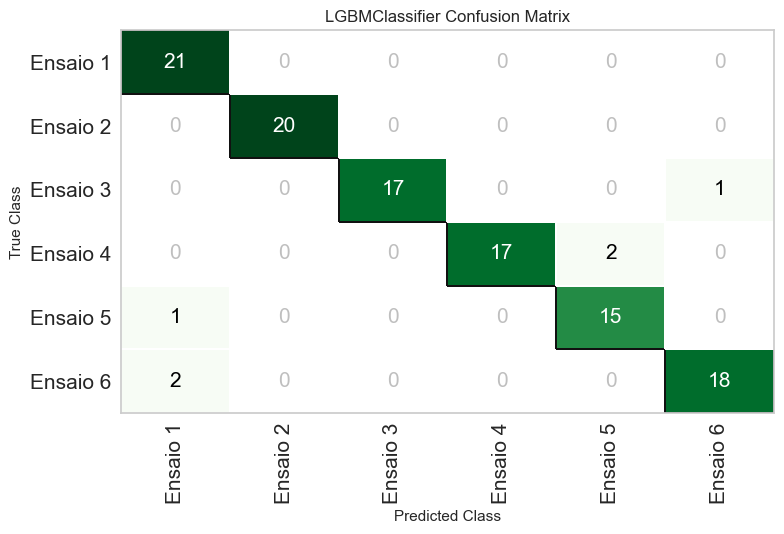

In [37]:
plot_model(clf, 'confusion_matrix')

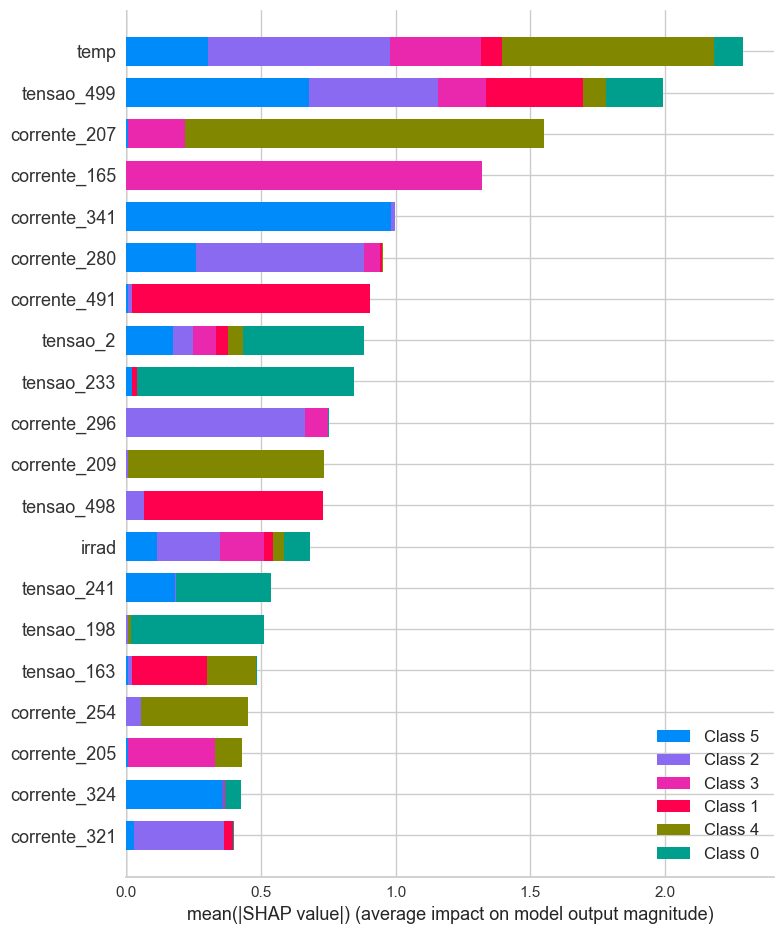

In [38]:
interpret_model(clf, feature='tensao_163')

In [ ]:
classes = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib as mpl

mpl.rcParams['font.size'] = 18
fig = plt.figure(figsize=(10, 8))
cm = confusion_matrix(preds.label_sombra, preds.Label)
sns.heatmap(cm, annot=True, fmt='.2g', xticklabels=classes, yticklabels=classes, cmap='Blues')

plt.xlabel('Classe predita', fontsize=12)
plt.ylabel('Classe verdadeira', fontsize=12)
plt.tight_layout()
# plt.show()
plt.savefig('matriz_confusao_exp1.jpg')

In [ ]:
plot_model(clf, 'feature')


In [ ]:
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.3g')

In [ ]:
fig = plt.figure(figsize=(24, 20))
sns.pairplot(data=df[features].drop(columns='label_sujeira'), hue='label_sombra', corner=True)
plt.savefig('figures/pairplot - sombra - variáveis reamostradas.jpg')

In [ ]:
df

In [ ]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 14
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.size'] = 14

In [ ]:
rename_mapper = {'irrad': 'Irradiação', 'corrente_1': 'Corrente 1', 'temp': 'Temperatura', 'tensao_499': 'Tensão 499', 'label_sujeira': 'Sujidade'}

sns.set_style(None)
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs.ravel()
sns.scatterplot(data=df.rename(columns=rename_mapper), x='Irradiação', y='Corrente 1', hue='Sujidade', palette=['blue', 'red'], ax=axs[0])
sns.scatterplot(data=df.rename(columns=rename_mapper), x='Temperatura', y='Tensão 499', hue='Sujidade', palette=['blue', 'red'], ax=axs[1])

axs[0].set_title('Relação entre as variáveis: Corrente 1 e Irradiação')
axs[1].set_title('Relação entre as variáveis: Tensão 499 e Temperatura')

sns.set(font_scale=1.2)

plt.tight_layout()
plt.savefig('./scatterplot - sujidade - reamostragem.jpg')
# plt.show()
plt.close()

In [ ]:
df

In [ ]:
sns.set_style(None)

fig, axs = plt.subplots(2, 2, figsize=(16,12))
axs = axs.ravel()
sns.scatterplot(data=df, x='irrad', y='tensao_499', hue='label_sombra', ax=axs[0])
sns.scatterplot(data=df, x='irrad', y='tensao_3', hue='label_sombra', ax=axs[1])
sns.scatterplot(data=df, x='temp', y='tensao_499', hue='label_sombra', ax=axs[2])
sns.scatterplot(data=df, x='tensao_499', y='tensao_3', hue='label_sombra', ax=axs[3])

axs[0].set_title('Relação entre as variáveis: Corrente 1 e Irradiação')
axs[1].set_title('Relação entre as variáveis: Tensão 499 e Temperatura')

sns.set(font_scale=1.2)

plt.tight_layout()
# plt.savefig('./scatterplot - sujidade - reamostragem.jpg')
plt.show()
plt.close()

In [ ]:
clf = create_model('ridge', verbose=True)

In [ ]:
preds = predict_model(clf)

In [ ]:
df

In [ ]:
sample = df.copy().drop(columns=['label_sombra']).round(1)

In [ ]:
sample

In [ ]:
fig = plt.figure(figsize=(8, 6))
sns.pairplot(data=sample, hue='label_sujeira', corner=True)

plt.show()
plt.close()

In [ ]:
sns.pairplot?